# Regression for denoising quasar spectra

## (a)
### (i) 
$W_{ij} = \frac{1}{2} w^{(i)}$ if $i = j$, $W_{ij} = 0$ if $i \neq j$

### (ii)
From $\nabla_{A^T} trABA^TC = B^TA^TC^T + BA^TC$. with $A = \theta^T, B= X^TWX,C=I$, we have
$$\nabla_\theta tr\theta^TX^TWX\theta = X^TW^TX\theta + X^TWX\theta = 2X^TWX\theta$$
Hence for the diagonalm matrix W
$$
\begin{align}
\nabla_\theta J(\theta) &= \nabla_\theta(X\theta-y)^TW(X\theta-y) \\
&= \nabla_\theta tr[\theta^TX^TWX\theta - \theta^TX^TWy - y^TWX\theta + y^TWy] \\
&= \nabla_\theta(tr\theta^TX^TWX\theta - 2tr \theta^TX^TWy) \\
&= 2X^TWX\theta - 2X^TW^Ty \\
&= 2(X^TWX - X^TWy)
\end{align}
$$
To minimize J, set $\nabla_\theta J(\theta) = 0$, we get new **normal equation** to this weighted setting:
$$\theta = (X^TWX)^{-1}X^TWy$$


### (iii)
Likelihood function $l(\theta)$
$$
\begin{align}
l(\theta) &= \sum_{i=1}^m \log{\frac{1}{\sqrt{2\pi}\sigma^{(i)}}} - \frac{(y^{(i)} - \theta^T x^{(i)})^2}{2(\sigma^{(i)})^2} \\
&= \sum_{i=1}^m \log{\frac{1}{\sqrt{2\pi}\sigma^{(i)}}} - \frac1 2  \sum_{i=1}^m \frac1 {(\sigma^{(i)})^2} {(y^{(i)} - \theta^T x^{(i)})^2}
\end{align}
$$
Hence, the maximum likelihood estimate of $\theta$ reduces to solving a weighted linear regression problem:
$$\frac1 2 \sum_{i=1}^m w^{(i)} {(y^{(i)} - \theta^T x^{(i)})^2}$$
, in which $w^{(i)} = \frac1 {(\sigma^{(i)})^2}$. 


## (b)
Set up for answers

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

In [4]:
import pandas as pd

def load_data():
    """load data from csv, return training, test data sets"""
    TRAIN_DATA_FILENAME = "quasar_train.csv"
    TEST_DATA_FILENAME = "quasar_test.csv"
    return pd.read_csv(TRAIN_DATA_FILENAME), pd.read_csv(TEST_DATA_FILENAME)

train_df, test_df = load_data()

def add_intercept(X_):
    m, n = X_.shape
    X = np.zeros((m, n + 1))
    X[:, 0] = 1
    X[:, 1:] = X_
    return X

In [5]:
# plot the data
def plot_data(X, Y):
    fig, ax = plt.subplots()
    ax.plot(X, Y)
    ax.set_xlabel('lambda')
    ax.set_ylabel('Flux')
    ax.xaxis.set_major_formatter(plt.NullFormatter())
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    plt.show()
    

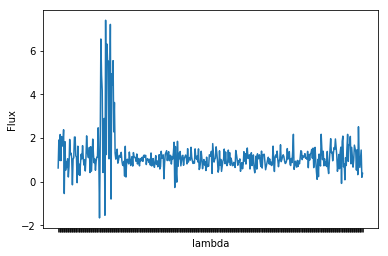

In [6]:
plot_data(train_df.iloc[0].index.values,train_df.iloc[0].values)
# np.arange(15)[-10:]
# train_df.iloc[0].values[-10:]

### (i) linear regression on the first training example

In [7]:
def linear_regression_non_weighted(X, Y):
    """a simple linear regression, return the parameter \theta"""
    ## Add intercept term
    return np.linalg.solve(np.matmul(X.T, X), np.matmul(X.T, Y))
#     a = np.matmul(X.T, X)
#     b = np.matmul(X.T, X)
#     return np.linalg.solve(a, b)
#     return np.linalg.lstsq(np.matmul(X.T, X), np.matmul(X.T, Y), rcond=None)


_X = add_intercept(pd.to_numeric(list(train_df)).reshape(-1, 1))
_Y = train_df.iloc[0].values.reshape(-1, 1)
_theta = linear_regression_non_weighted(_X, _Y)
_theta

array([[ 2.51339906e+00],
       [-9.81122145e-04]])

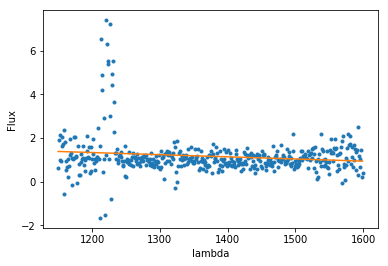

In [8]:
def plot_linear_function(theta, X, Y):
    fig, ax = plt.subplots()
    ax.plot(X, Y, '.')
    ax.set_xlabel('lambda')
    ax.set_ylabel('Flux')
    
    x = np.array([np.min(X), np.max(X)])
#     theta.T.dot(x)
    mx = add_intercept(x.reshape(2,1))
    ax.plot(x, np.matmul(mx, theta).squeeze())
    plt.show()
    
# theta.shape
# x = np.array([1,2]).reshape(2,1)
# np.matmul(theta.T, x)
plot_linear_function(_theta, _X[:, 1:], _Y)

### (ii)locally weighted linear regression on the first training example

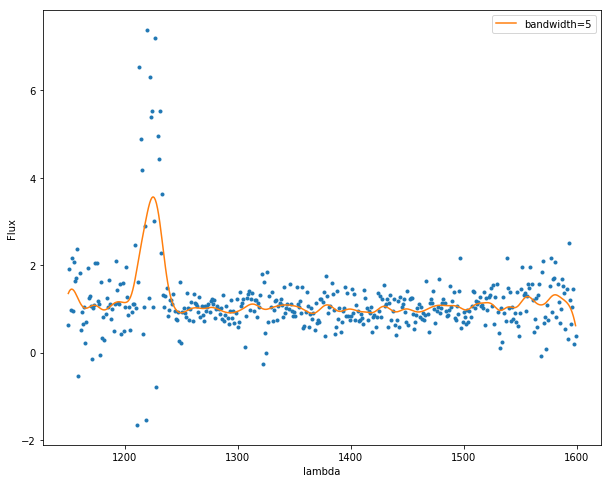

In [9]:
# %debug
def locally_weighted_linear_regression(X, Y, query_point, bandwidth=5):
    """A locally weighted linear regression, return the parameter \theta"""
    diff = X[:, 1:] - query_point
    diff_squares = np.sum(diff*diff, axis=1)
    W = np.diagflat(0.5 * np.exp(-0.5 * diff_squares/bandwidth**2))
    return np.linalg.solve(X.T @ W @ X, X.T @ W @Y)

# Wrong Answer!!
def plot_weighted_linear_functions_wrong(X, Y, query_index, plt_width, bandwidths):
    """plot linear functions with parameter theta which is derived by locally weighted linear regression.
    
    Args:
        X: Features variables. A (m, 2) array with the intercept item
        Y: Traget variable. A (m,1) array
        query_index: [0:m), at this index we apply the locally weighted linear regression
        plt_width: the width of plotted data centered at query_index, will be clippe if out of range
        bandwithds: a list of bandwidth parameters.
    """
    #raise Exception("Wrong Answer")
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xlabel('lambda')
    ax.set_ylabel('Flux')
    
    qp = X[query_index, 1]
    
    # plot data
    idx_start = query_index-plt_width//2
    idx_start = np.clip(idx_start, 0, X.shape[0]-1)
    idx_end = query_index+plt_width//2+1
    idx_end = np.clip(idx_end, 1, X.shape[0])

    x_min = X[idx_start, 1]
    x_max = X[idx_end-1, 1]
    ax.plot(X[idx_start:idx_end, 1].squeeze(),
            Y[idx_start:idx_end].squeeze(), '.')

    # plot h(x)
#     np.set_printoptions(precision=3)
    for bandwidth in bandwidths:
        weighted_theta = locally_weighted_linear_regression(X, Y, qp, bandwidth)
        x = np.array([x_min, x_max])
        y = add_intercept(x.reshape(2,1)) @ weighted_theta
        ax.plot(x, y, label=f"{bandwidth}, $\\theta$={weighted_theta}")
        
    plt.legend()
    plt.show()
    

def plot_weighted_linear_functions(X, Y, bandwidths):
    """plot linear functions with parameter theta which is derived by locally weighted linear regression.
    
    Args:
        X: Features variables. A (m, 2) array with the intercept item
        Y: Traget variable. A (m,1) array
        bandwithds: a list of bandwidth parameters.
    """
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xlabel('lambda')
    ax.set_ylabel('Flux')
        
    # plot data
    ax.plot(X[:, 1].squeeze(),Y.squeeze(), '.')

    # plot h(x)
    for bandwidth in bandwidths:
        y = np.zeros(X.shape[0],)
        for i, qp in enumerate(X[:, 1]):
            weighted_theta = locally_weighted_linear_regression(X, Y, qp, bandwidth)
            y[i] = weighted_theta.flatten().dot([1, qp])
        ax.plot(X[:,1].squeeze(), y, label=f"bandwidth={bandwidth}")
        
    plt.legend()
    plt.show()


    
plot_weighted_linear_functions(_X, _Y, [5])

TypeError: 'int' object is not iterable

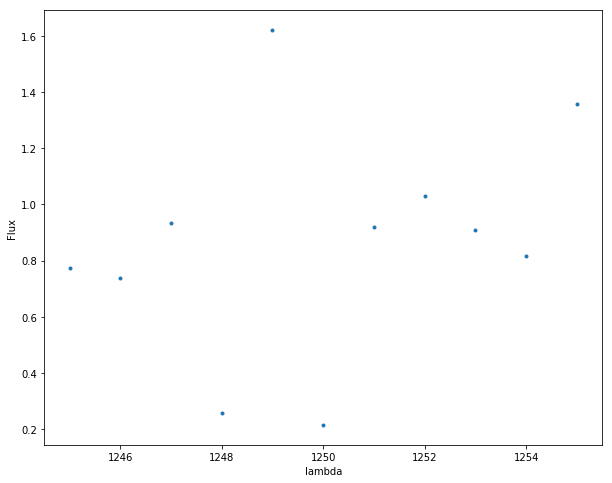

In [11]:
plot_weighted_linear_functions_wrong(_X, _Y, 100, 10, 5)

### (iii) 4 different bandwidths

In [ ]:
plot_weighted_linear_functions(_X, _Y, [1,10,100,1000])
        

As bandwidth $\tau$ become larger, 

## (c) Predicting quasar spectra with functional regression
### (i) Smooth all spectra.

In [ ]:
def smoothed_spertra(df):
    """return (X, smoothed_Y), which smoothed_Y is smoothed_spectra"""
    X = add_intercept(pd.to_numeric(df.iloc[0].index.values).reshape(-1, 1))
    smoothed_Y = np.zeros_like(df)
    
    for i, row in df.iterrows():
        for j, qp in enumerate(X[:, 1]):
            weighted_theta = locally_weighted_linear_regression(X, row.values.reshape(-1, 1), qp, 5)
            smoothed_Y[i, j] = weighted_theta.flatten().dot([1, qp])
    return X[:,1], smoothed_Y
        

### (ii) Nonparametric functional regression

In [ ]:
# %debug
RIGHT_FREQ = 1300.0
LEFT_FREQ  = 1200.0

def metric(f1, f2):
    """a metric of two functions"""
    return np.sum((f2-f1)**2, axis=1)

def neighb_k(k:int, fs:list, f:list)-> list: 
    """return the k indics that are closest to f in fs
    
    Args:
        k: the closest k indics to f
        fs: A (m x n) array, the functions in which to find k closest indics.
        
    Returns:
        a list of the k indics.
    """
    return np.argpartition(metric(fs, f), k)[:k]

def ker(t):
    a = 1-t
    a[a<0] = 0
    return a

def estimated_function_left(X, smoothed_Y):
    fs_left = smoothed_Y[:, X<LEFT_FREQ]
    fs_right = smoothed_Y[:, X>=RIGHT_FREQ]
    estimated_fs_left = np.zeros_like(fs_left)
    for i, f_right in enumerate(fs_right):
        h = np.max(metric(fs_right, f_right))
        idcs = neighb_k(3, fs_right, f_right)
#         pdb.set_trace()
        # estimate fs_left by a locally weighted sum of functions f_left from the data.
        estimated_fs_left[i] = np.sum(
            ker(metric(fs_right[idcs], f_right) / h).reshape(-1, 1)  * fs_left[idcs], axis=0) / np.sum(
            ker(metric(fs_right[idcs], f_right) / h))
    return estimated_fs_left
    
def average_error(fs_left, estimated_fs_left):
    return np.mean(metric(fs_left, estimated_fs_left))

def average_error_on_data(df):
    X, smoothed_Y = smoothed_spertra(df)
    estimated_fs_left = estimated_function_left(X, smoothed_Y)
    return average_error(smoothed_Y[:, X<LEFT_FREQ], estimated_fs_left)
    
print(f"average error on training data:{average_error_on_data(train_df)}")


### (iii) plot function regression on test data 

In [ ]:
print(f"average error on test data:{average_error_on_data(test_df)}")

In [ ]:
def plot_functional_regression_on_data(df, example_indics):
    if not (isinstance(example_indics, np.ndarray)
            or isinstance(example_indics, list)):
        example_indics = np.array(example_indics)
        
    X, smoothed_Y = smoothed_spertra(df)
    estimated_fs_left = estimated_function_left(X, smoothed_Y)
    fs_left = smoothed_Y[np.ix_(example_indics, X<LEFT_FREQ)]

    m = len(example_indics)
    plt.figure(figsize=(10,6*m))
    
    for i in range(m):
        plt.subplot(m, 1, i+1)
        idx = example_indics[i]
        plt.title(f"Example {idx+1}")
        plt.xlabel('lambda')
        plt.ylabel('flux')
        plt.plot(X, smoothed_Y[idx])
        plt.plot(X[X<LEFT_FREQ], estimated_fs_left[idx], 'r')
    plt.show()
    
plot_functional_regression_on_data(test_df, [0,5])